In [2]:
import pandas as pd
import geopandas as gp
import numpy as np
from datetime import datetime

import sqlite3, psycopg2, sqlalchemy
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import chart_studio.plotly as cs
import plotly.io as pio
pio.base_renderers = "notebook"
import re
import os

### Task 3: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

### NOTE: The data used for this project is same as task 2's data, aka delays data

In [7]:
data = pd.read_csv("all_delays.csv").drop("Unnamed: 0", axis=1)

In [8]:
data

,fl_date,dep_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,arr_delay
0,2018-08-13,-3.0,NaN,NaN,NaN,NaN,NaN,0.0
1,2018-08-13,-9.0,NaN,NaN,NaN,NaN,NaN,8.0
2,2018-08-13,-3.0,NaN,NaN,NaN,NaN,NaN,7.0
3,2018-08-13,-5.0,NaN,NaN,NaN,NaN,NaN,4.0
4,2018-08-13,-3.0,NaN,NaN,NaN,NaN,NaN,-4.0
...,...,...,...,...,...,...,...,...
15658272,2018-08-13,86.0,32.0,0.0,0.0,0.0,36.0,68.0
15658273,2018-08-13,12.0,1.0,0.0,3.0,0.0,11.0,15.0
15658274,2018-08-13,1.0,NaN,NaN,NaN,NaN,NaN,11.0
15658275,2018-08-13,64.0,0.0,0.0,0.0,0.0,60.0,60.0


In [9]:
#drop nulls and reset index
delay = data[data["arr_delay"] > 0].dropna(axis=0).reset_index(drop=True)

<AxesSubplot:>

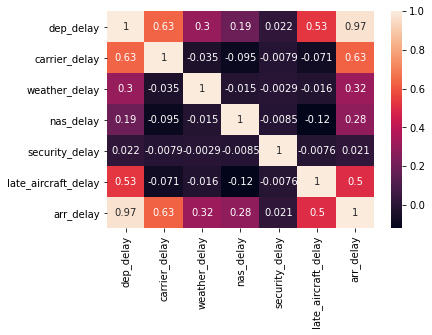

In [11]:
#look for corelation 
delay_corr = delay.corr()
sns.heatmap(delay_corr, annot=True)

In [12]:
#test the hypothesis whether delays (except dep_delay) = arr_delay, return True
def check(delay):
    if delay["carrier_delay"] + delay["weather_delay"] + delay["nas_delay"] + delay["security_delay"] + delay["late_aircraft_delay"] == delay["arr_delay"]:
        return "True"
    else:
        return "False"

In [14]:
#apply the function and count the number of false (test hypothesis)
is_true = delay.apply(check, axis=1)
is_true_df = pd.DataFrame(is_true)
is_true_df[is_true_df[0] == "False"].count()

0    34
dtype: int64

In [15]:
delay = delay.drop(["fl_date", "dep_delay"], 1)

In [30]:
#get percentages of each delay
def average(delay):
    total = delay["carrier_delay"] + delay["weather_delay"] + delay["nas_delay"] + delay["security_delay"]
    delay["carrier_delay"] =  round(delay["carrier_delay"] / delay["arr_delay"], 2)
    delay["weather_delay"] =  round(delay["weather_delay"] / delay["arr_delay"], 2)
    delay["nas_delay"] =  round(delay["nas_delay"] / delay["arr_delay"], 2)
    delay["security_delay"] =  round(delay["security_delay"] / delay["arr_delay"], 2)
    delay["late_aircraft_delay"] =  round(delay["late_aircraft_delay"] / delay["arr_delay"], 2)
    delay["arr_delay"] =  round(delay["arr_delay"] / delay["arr_delay"], 2)

In [ ]:
delay = delay.apply(average, axis=1)

In [44]:
delay.to_csv("percent_delay.csv")

### All the above process is saved to average_delays.csv
###### Read the list

In [41]:
average_percentage_delay = pd.DataFrame(delay.mean(), columns=["average_percentages"]).reset_index()

In [42]:
#drop arr_delays and test if all = 100%
average_percentage_delay.drop(5, 0).sum()

index                  carrier_delayweather_delaynas_delaysecurity_de...
average_percentages                                             0.999998
dtype: object

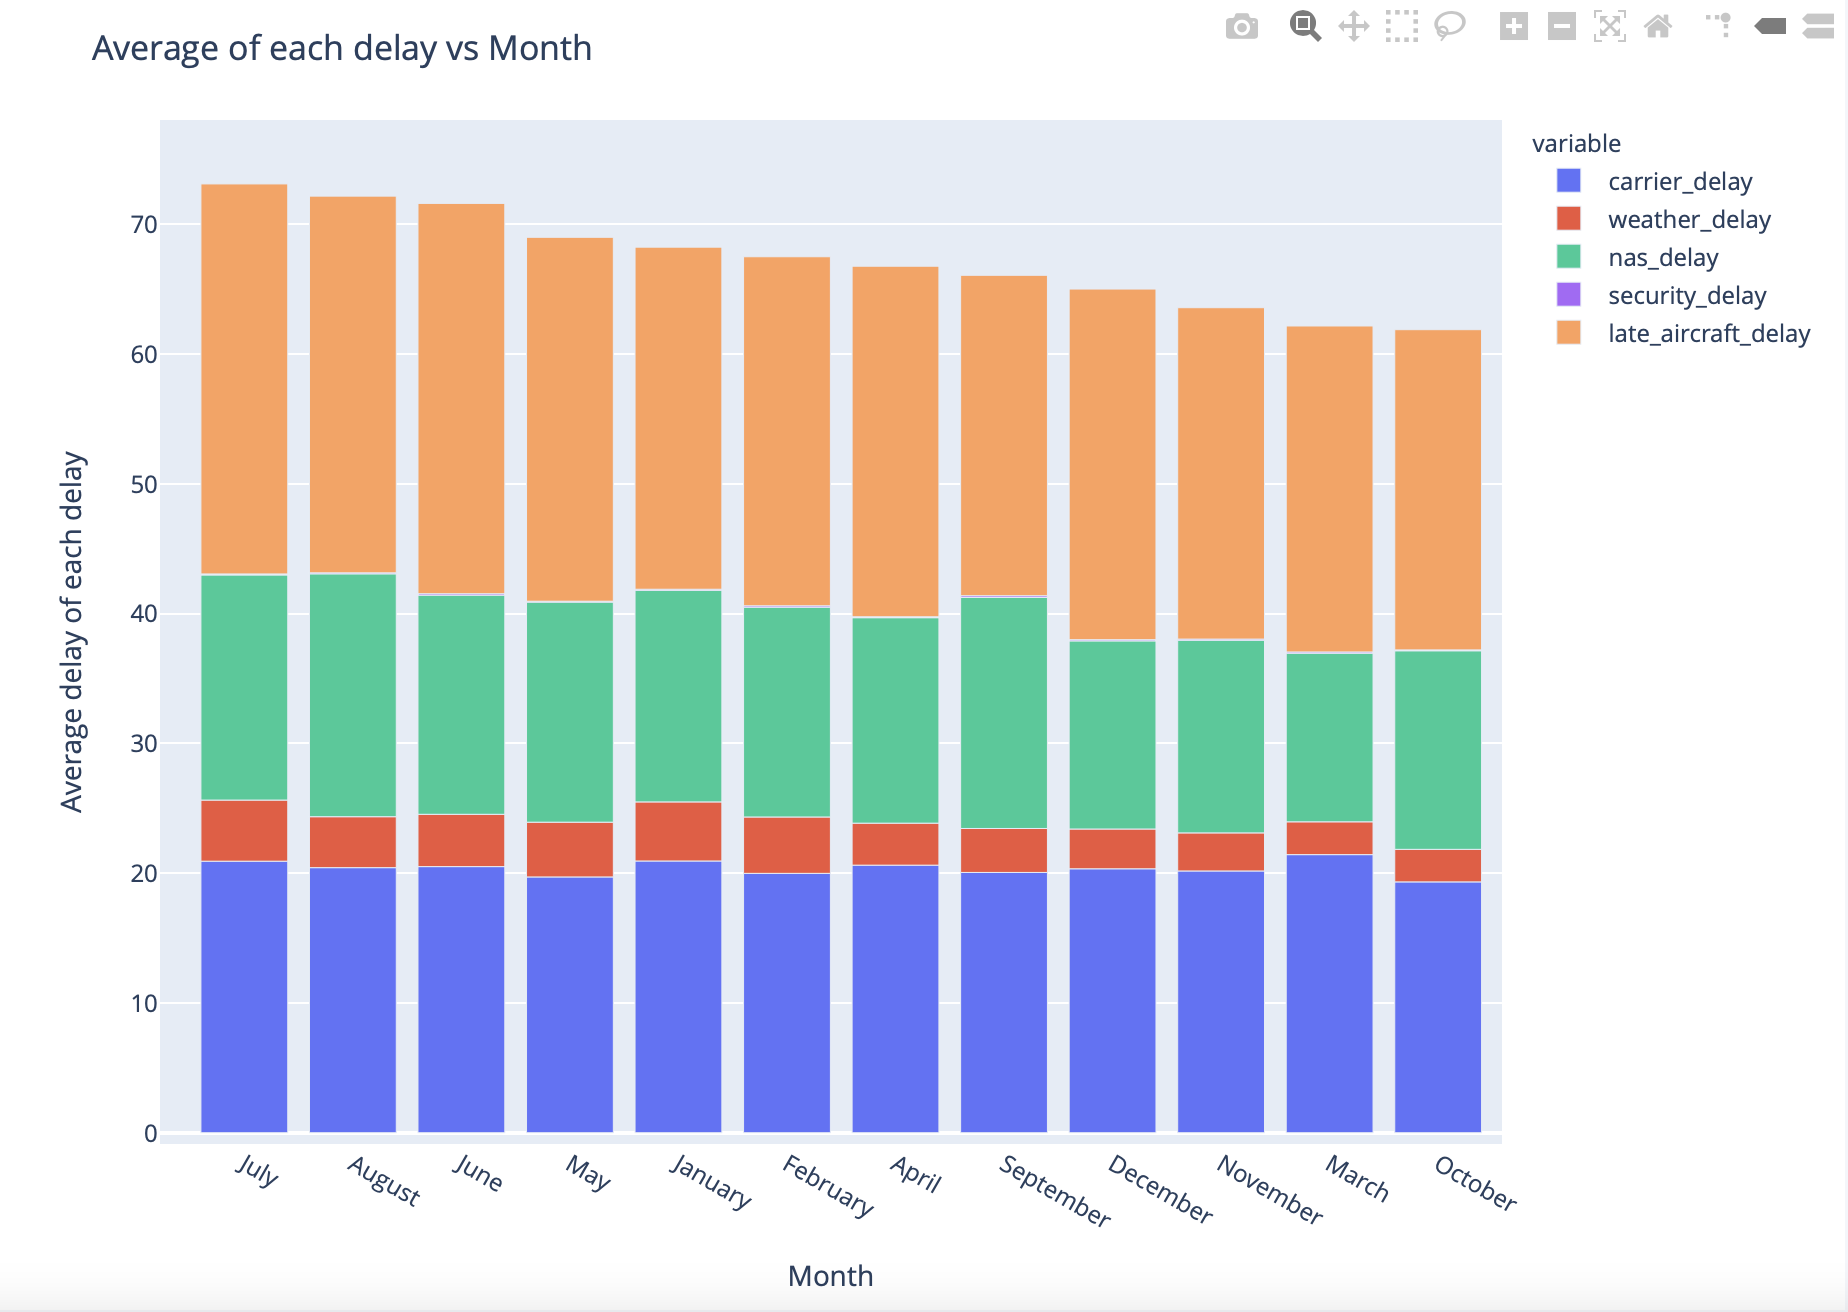

In [3]:
from IPython.display import Image
os.chdir("/Users/yonussahadat/Desktop/LHL-DataScience/projects_tests/Midterm/organized_exploratory_analysis/task_3")
Image("avg_delay.png")

In [43]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=average_percentage_delay.drop(5,0)["index"],
                             values=average_percentage_delay.drop(5,0)['average_percentages'],
                    pull=[0, 0, 0.15, 0, 0])])

fig.update_layout(
            xaxis=dict(
            tickmode="linear",
            categoryorder="total descending"),
            title="Percentage of delays")
fig.show()